# Coverage control for a MRS in an uniformly distributed environment

In [ ]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import random
from shapely import Polygon, Point, intersection

epochs = 1000
ROBOTS_NUM = 12
AREA_W = 20.0

In [ ]:
def mirror(points):
    mirrored_points = []

    # Define the corners of the square
    square_corners = [(-0.5*AREA_W, -0.5*AREA_W), (0.5*AREA_W, -0.5*AREA_W), (0.5*AREA_W, 0.5*AREA_W), (-0.5*AREA_W, 0.5*AREA_W)]

    # Mirror points across each edge of the square
    for edge_start, edge_end in zip(square_corners, square_corners[1:] + [square_corners[0]]):
        edge_vector = (edge_end[0] - edge_start[0], edge_end[1] - edge_start[1])

        for point in points:
            # Calculate the vector from the edge start to the point
            point_vector = (point[0] - edge_start[0], point[1] - edge_start[1])

            # Calculate the mirrored point by reflecting across the edge
            mirrored_vector = (point_vector[0] - 2 * (point_vector[0] * edge_vector[0] + point_vector[1] * edge_vector[1]) / (edge_vector[0]**2 + edge_vector[1]**2) * edge_vector[0],
                               point_vector[1] - 2 * (point_vector[0] * edge_vector[0] + point_vector[1] * edge_vector[1]) / (edge_vector[0]**2 + edge_vector[1]**2) * edge_vector[1])

            # Translate the mirrored vector back to the absolute coordinates
            mirrored_point = (edge_start[0] + mirrored_vector[0], edge_start[1] + mirrored_vector[1])

            # Add the mirrored point to the result list
            mirrored_points.append(mirrored_point)

    return mirrored_points

In [ ]:
def gauss_pdf(x, y, mean, covariance):

  points = np.column_stack([x.flatten(), y.flatten()])
  # Calculate the multivariate Gaussian probability
  exponent = -0.5 * np.sum((points - mean) @ np.linalg.inv(covariance) * (points - mean), axis=1)
  coefficient = 1 / np.sqrt((2 * np.pi) ** 2 * np.linalg.det(covariance))
  prob = coefficient * np.exp(exponent)

  return prob

Converged in 28 iterations


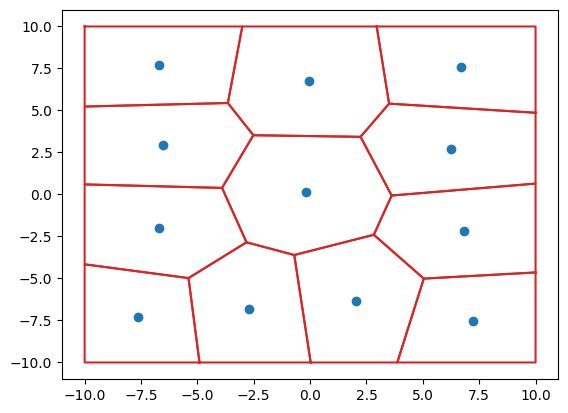

In [ ]:
converged = False
NUM_STEPS = 100
points = -0.5*AREA_W + AREA_W * np.random.rand(ROBOTS_NUM, 2)
# fig, axs = plt.subplots(2, int(NUM_STEPS/2), figsize=(18,5))
for s in range(1, NUM_STEPS+1):
  row = 0
  if s > 5:
    row = 1

  # mirror points across each edge of the env
  dummy_points = np.zeros((5*ROBOTS_NUM, 2))
  dummy_points[:ROBOTS_NUM, :] = points
  mirrored_points = mirror(points)
  mir_pts = np.array(mirrored_points)
  dummy_points[ROBOTS_NUM:, :] = mir_pts

  # Voronoi partitioning
  vor = Voronoi(dummy_points)

  conv = True
  lim_regions = []
  for idx in range(ROBOTS_NUM):
    region = vor.point_region[idx]
    poly_vert = []
    for vert in vor.regions[region]:
      v = vor.vertices[vert]
      poly_vert.append(v)
      # plt.scatter(v[0], v[1], c='tab:red')

    poly = Polygon(poly_vert)
    x,y = poly.exterior.xy
    # plt.plot(x, y, c='tab:orange')
    # robot = np.array([-18.0, -12.0])
    robot = vor.points[idx]
    # plt.scatter(robot[0], robot[1])

    # Intersect with robot range
    ROBOT_RANGE = 5.0
    step = 0.5
    range_pts = []
    for th in np.arange(0.0, 2*np.pi, step):
      xi = robot[0] + ROBOT_RANGE * np.cos(th)
      yi = robot[1] + ROBOT_RANGE * np.sin(th)
      pt = Point(xi, yi)
      range_pts.append(pt)
      # plt.plot(xi, yi, c='tab:blue')

    range_poly = Polygon(range_pts)
    xc, yc = range_poly.exterior.xy

    lim_region = intersection(poly, range_poly)
    lim_regions.append(lim_region)
    centr = np.array([lim_region.centroid.x, lim_region.centroid.y])
    dist = np.linalg.norm(robot-centr)
    points[idx, :] = robot + 0.5 * (centr - robot)
    if dist > 0.1:
      conv = False

  if conv:
    print(f"Converged in {s} iterations")
    break
  # axs[row, s-1-5*row].scatter(points[:, 0], points[:, 1])


plt.scatter(points[:, 0], points[:, 1])
for region in lim_regions:
  x,y = region.exterior.xy
  plt.plot(x, y, c="tab:red")

# plt.plot([xmin, xmax], [ymin, ymin])
# plt.plot([xmax, xmax], [ymin, ymax])
# plt.plot([xmax, xmin], [ymax, ymax])
# plt.plot([xmin, xmin], [ymax, ymin])


(-1.970143866385405,
 -0.39300252047846485,
 5.127366708175716,
 6.145691444294279)

## Gaussian Distribution

Converged in 35 iterations


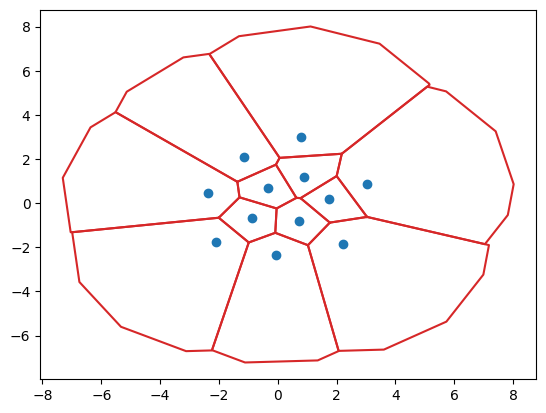

In [ ]:
converged = False
NUM_STEPS = 100
GAUSS_PT = np.zeros((1, 2))
GAUSS_COV = 2.0*np.eye(2)
points = -0.5*AREA_W + AREA_W * np.random.rand(ROBOTS_NUM, 2)
discretize_precision = 0.5
# fig, axs = plt.subplots(2, int(NUM_STEPS/2), figsize=(18,5))
for s in range(1, NUM_STEPS+1):
  row = 0
  if s > 5:
    row = 1

  # mirror points across each edge of the env
  dummy_points = np.zeros((5*ROBOTS_NUM, 2))
  dummy_points[:ROBOTS_NUM, :] = points
  mirrored_points = mirror(points)
  mir_pts = np.array(mirrored_points)
  dummy_points[ROBOTS_NUM:, :] = mir_pts

  # Voronoi partitioning
  vor = Voronoi(dummy_points)

  conv = True
  lim_regions = []
  for idx in range(ROBOTS_NUM):
    region = vor.point_region[idx]
    poly_vert = []
    for vert in vor.regions[region]:
      v = vor.vertices[vert]
      poly_vert.append(v)
      # plt.scatter(v[0], v[1], c='tab:red')

    poly = Polygon(poly_vert)
    x,y = poly.exterior.xy
    # plt.plot(x, y, c='tab:orange')
    # robot = np.array([-18.0, -12.0])
    robot = vor.points[idx]
    # plt.scatter(robot[0], robot[1])

    # Intersect with robot range
    ROBOT_RANGE = 5.0
    step = 0.5
    range_pts = []
    for th in np.arange(0.0, 2*np.pi, step):
      xi = robot[0] + ROBOT_RANGE * np.cos(th)
      yi = robot[1] + ROBOT_RANGE * np.sin(th)
      pt = Point(xi, yi)
      range_pts.append(pt)
      # plt.plot(xi, yi, c='tab:blue')

    range_poly = Polygon(range_pts)
    xc, yc = range_poly.exterior.xy

    lim_region = intersection(poly, range_poly)
    lim_regions.append(lim_region)

    # Calculate centroid with gaussian distribution
    xmin, ymin, xmax, ymax = lim_region.bounds
    A = 0.0
    Cx = 0.0; Cy = 0.0
    dA = discretize_precision ** 2
    # pts = [Point(xmin, ymin), Point(xmax, ymin), Point(xmax, ymax), Point(xmin, ymax)]
    # bound = Polygon(pts)
    for i in np.arange(xmin, xmax, discretize_precision):
      for j in np.arange(ymin, ymax, discretize_precision):
        pt_i = Point(i,j)
        if lim_region.contains(pt_i):
          dA_pdf = dA * gauss_pdf(i, j, GAUSS_PT, GAUSS_COV)
          # print(dA_pdf)
          A = A + dA_pdf
          Cx += i*dA_pdf
          Cy += j*dA_pdf

    Cx = Cx / A
    Cy = Cy / A


    # centr = np.array([lim_region.centroid.x, lim_region.centroid.y])
    centr = np.array([Cx, Cy]).transpose()
    # print(f"Robot: {robot}")
    # print(f"Centroid: {centr}")
    dist = np.linalg.norm(robot-centr)
    points[idx, :] = robot + 0.8 * (centr - robot)
    if dist > 0.1:
      conv = False

  if conv:
    print(f"Converged in {s} iterations")
    break
  # axs[row, s-1-5*row].scatter(points[:, 0], points[:, 1])


plt.scatter(points[:, 0], points[:, 1])
for region in lim_regions:
  x,y = region.exterior.xy
  plt.plot(x, y, c="tab:red")
